In [1]:
import numpy as np
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator
from landlab.components import DepressionFinderAndRouter
from landlab.components import ErosionDeposition
from landlab.components import FastscapeEroder

from landlab.plot.imshow import imshow_grid
import time



np.random.seed(seed = 5000)


erode_steps = 25




time taken: 0.223 seconds


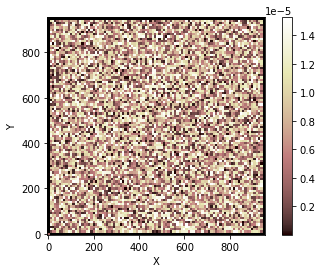

In [2]:
start_time = time.time()


nr = 96 # height
nc = 96 # width

dx = 100
mg = RasterModelGrid((nr, nc), xy_spacing=10.0)
_ = mg.add_zeros('node', 'topographic__elevation')
# mg['node']['topographic__elevation'] += (mg.node_y/10 +
#         mg.node_x/10 + np.random.rand(len(mg.node_y)) / 10)

mg['node']['topographic__elevation'] += (np.random.rand(len(mg.node_y))/256.0/16.0/16.0)





# mg.set_closed_boundaries_at_grid_edges(
#         bottom_is_closed=True,
#         left_is_closed=True,
#         right_is_closed=True,
#         top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
fsc_dt = 100.
ed_dt = 1.


imshow_grid(mg, 'topographic__elevation')


print("time taken: {:.3f} seconds".format(time.time() - start_time))

time taken: 18.409 seconds


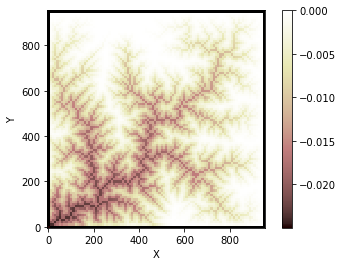

In [3]:
## ERODE 222

start_time = time.time()


fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)
fsc = FastscapeEroder(
    mg,
    K_sp=.002,
    m_sp=.5,
    n_sp=1)




for x in range(erode_steps):
    fr.run_one_step()
    df.map_depressions()
    flooded = np.where(df.flood_status==3)[0]
    fsc.run_one_step(dt = fsc_dt)
    mg.at_node['topographic__elevation'][0] -= 0.001 #uplift

imshow_grid(mg, 'topographic__elevation')
#     plt.show()

print("time taken: {:.3f} seconds".format(time.time() - start_time))

In [4]:
# ## ERODE 222

# start_time = time.time()


# fr = FlowAccumulator(mg, flow_director='D8')
# df = DepressionFinderAndRouter(mg)
# fsc = FastscapeEroder(
#     mg,
#     K_sp=.002,
#     m_sp=.5,
#     n_sp=1)




# for x in range(erode_steps):
#     fr.run_one_step()
#     df.map_depressions()
#     flooded = np.where(df.flood_status==3)[0]
#     fsc.run_one_step(dt = fsc_dt)
#     mg.at_node['topographic__elevation'][0] -= 0.001 #uplift

# imshow_grid(mg, 'topographic__elevation')
# #     plt.show()

# print("time taken: {:.3f} seconds".format(time.time() - start_time))

In [5]:
# start_time = time.time()

# ed = ErosionDeposition(
#     mg,
#     K=0.00001,
#     v_s=0.001,
#     m_sp=0.5,
#     n_sp = 1.0,
#     sp_crit=0)

# for x in range(100): #E/D component loop
#     fr.run_one_step()
#     df.map_depressions()
#     ed.run_one_step(dt = ed_dt)
#     mg.at_node['topographic__elevation'][0] -= 2e-4 * ed_dt

    
# # >>> np.around(mg.at_node['topographic__elevation'], decimals=3) # doctest: +NORMALIZE_WHITESPACE
# imshow_grid(mg, 'topographic__elevation')

# print("time taken: {:.3f} seconds".format(time.time() - start_time))

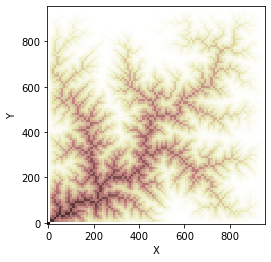

In [6]:
imshow_grid(
    mg,
    'topographic__elevation',
    allow_colorbar = False,
    color_for_closed=None
)




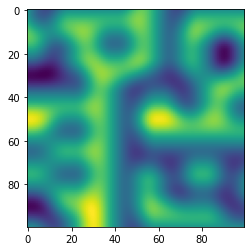

In [7]:


## perlin source:
## https://stackoverflow.com/questions/42147776/producing-2d-perlin-noise-with-numpy

import numpy as np
import matplotlib.pyplot as plt

def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

lin = np.linspace(0,5,100,endpoint=False)
x,y = np.meshgrid(lin,lin) # FIX3: I thought I had to invert x and y here but it was a mistake

plt.imshow(perlin(x,y,seed=2),origin='upper')






max_height:  1.52274433876e-05
min_height:  -0.0249965050069


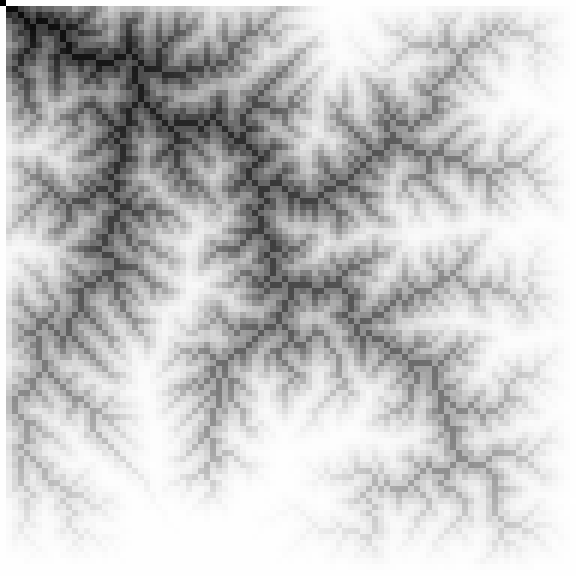

In [20]:
from PIL import Image

def newImg():
    
    width = nc
    height = nr
    
    image_scale = (6,6)
    
#     width = 128
#     height = 128
    
    img = Image.new('RGB', (width, height))
    
    ## modes https://pillow.readthedocs.io/en/stable/handbook/concepts.html
    

    elevations = mg['node']['topographic__elevation']
    
    max_height = max(elevations)
    min_height = min(elevations)
        
    # this is the range of the height, say from -3 to 7 is a range of 10
    # we use this to divide the final value to normalize
    height_range = max_height - min_height 
    
    print("max_height: ", max_height)
    print("min_height: ", min_height)
    
    for y in range(height):
        for x in range(width):
            
            ref = y * width + x
            
            elevation = elevations[ref]
            
            ## normalize our value (make between 0-1)
            elevation -= min_height
            elevation /= height_range
            
            col_val = int(elevation * 255.0)
            
            img.putpixel((x,y), (col_val,col_val,col_val))
            
#     img.save('sqr.png')
    
    img = img.resize((width*image_scale[0],height*image_scale[1]), Image.NEAREST)
    
    return img

wallpaper = newImg()
wallpaper = wallpaper.resize((width*image_scale[0],height*image_scale[1]), Image.NEAREST)

wallpaper.show()


